In [14]:
import yaml

import numpy as np
import matplotlib.pyplot as plt

from notebooks.estimagic.auxiliary import prepare_estimation
from notebooks.estimagic.auxiliary import get_moments
from notebooks.estimagic.SimulationBasedEstimation import SimulationBasedEstimationCls

In [11]:
lower = np.tile(
    (
        1.000,
        1.000,
        1.000,
        0.050,
        0.050,
        0.050,
        0.005,
        0.005,
        0.005,
        0.001,
        0.001,
        0.001,
        1.00,
        1.00,
        -0.400,
        -0.800,
        -0.400,
        -0.800,
        0.001,
        0.001,
        0.001,
        0.001,
        0.001,
    ),
    1,
)

upper = np.tile(
    (
        3.000,
        3.000,
        3.000,
        0.400,
        0.400,
        0.400,
        0.600,
        0.600,
        0.600,
        0.150,
        0.150,
        0.150,
        4.00,
        4.00,
        -0.050,
        -0.150,
        -0.050,
        -0.150,
        0.999,
        0.999,
        0.800,
        0.800,
        0.800,
    ),
    1,
)

model_params_init_file_name = "init_files/toy_model_init_file_03_3types.pkl"
model_spec_init_file_name = "init_files/model_spec_init_delta_test.yml"
data_file_name = "init_files/data_obs_3types_9000.pkl"
log_file_name_extension = "change_delta"


moments_obs, weighting_matrix, model_params_df = prepare_estimation(
    model_params_init_file_name, model_spec_init_file_name, data_file_name, lower, upper
)

max_evals = 10

delta_container = [0.98, 0.95, 0.90, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, 0.98]

fval = np.full(len(delta_container), np.nan)

i = 0

for delta in delta_container:

    with open("init_files/model_spec_init_delta_test.yml") as f:
         model_spec_init = yaml.load(f, Loader=yaml.FullLoader)

    model_spec_init["CONSTANTS"]["delta"] = delta
    print(delta)

    with open("init_files/model_spec_init_delta_test.yml", "w") as f:
        yaml.dump(model_spec_init, f)

    adapter_smm = SimulationBasedEstimationCls(
        params=model_params_df,
        model_spec_init_file_name=model_spec_init_file_name,
        moments_obs=moments_obs,
        weighting_matrix=weighting_matrix,
        get_moments=get_moments,
        log_file_name_extension=log_file_name_extension,
        max_evals=max_evals,
    )

    fval[i] = SimulationBasedEstimationCls.get_objective(adapter_smm, model_params_df)
    i += 1

0.98
0.43486846705627996
0.95
0.924594362700641
0.9
3.1125659222425472
0.85
6.621430976903864
0.8
10.75091149829092
0.7
19.697829850289217
0.6
30.00487784745781
0.5
40.14548259571073
0.4
50.13985298777073
0.3
58.99918659115072
0.2
68.33487836882185
0.1
77.09183191844271
0.0
85.433094313673
0.98
0.43486846705627996


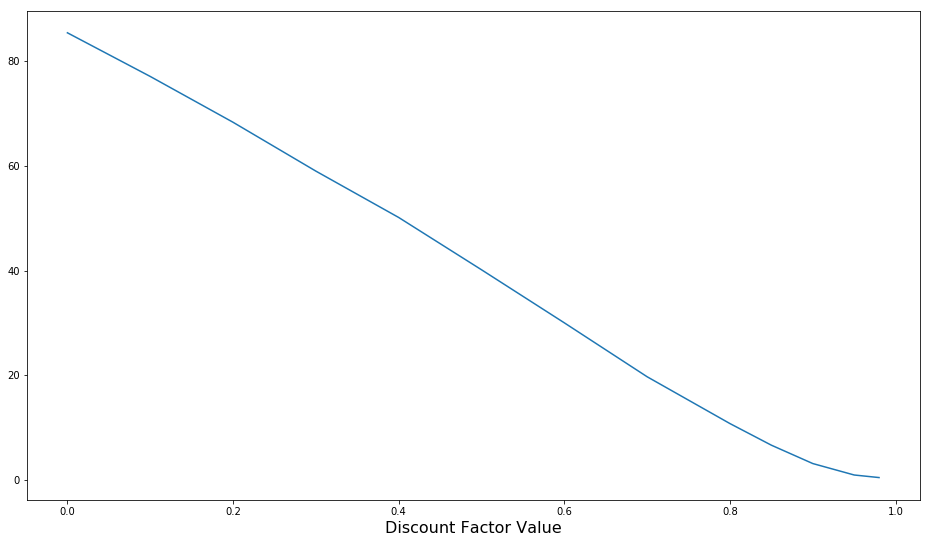

In [17]:
# Start plot
ax = plt.figure(figsize=[16,9]).add_subplot(111)
ax.set_xlabel("Discount Factor Value", fontsize=16)

plt.plot(delta_container[:-1], fval[:-1])